# Principal Components of the RSI

A predictive model based trading strategy using the principal components of several RSI periods. Principal component analysis seeks to reduce dimensionality while preserving the maximum amount of information or variance. The model shown uses only the RSI as an input and is still quite effective. The principal components of the RSI and other indicators can be effective features for machine learning based trading strategies.

* Tutorial: [Principal Components of the RSI | Machine Learning Trading Strategy in Python](https://www.youtube.com/watch?v=mdncZ034Q7k)
* Full Code: https://github.com/neurotrader888/RSI-PCA

Links
- https://en.wikipedia.org/wiki/Principal_component_analysis
- https://en.wikipedia.org/wiki/Relative_strength_index

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg as la
from typing import List
from tqdm.notebook import tqdm

### Visualizing the RSI

In [2]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [3]:
rsi_periods = list(range(2, 25))

rsis = pd.DataFrame()
for p in rsi_periods:
    rsis[p] = ta.rsi(data['close'], p)

plt.style.use('dark_background')

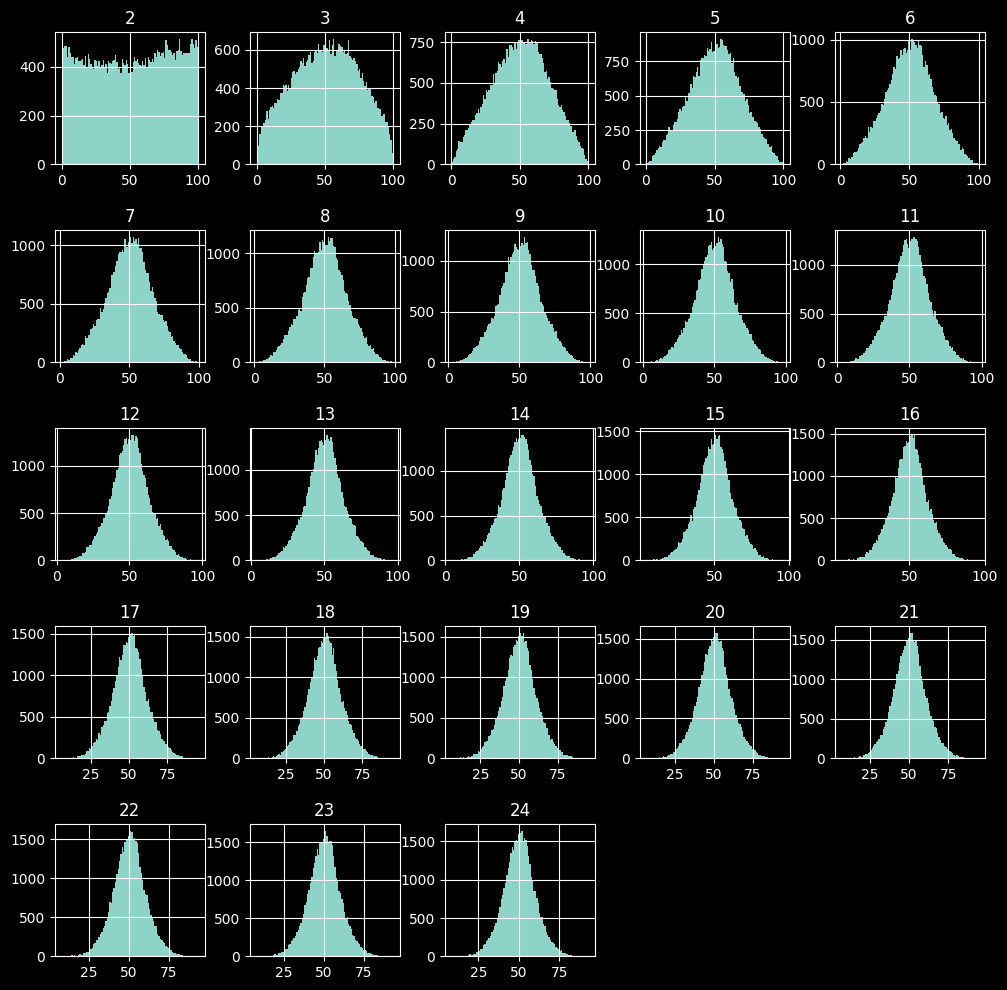

In [4]:
rsis.hist(bins=100, figsize=(12, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()

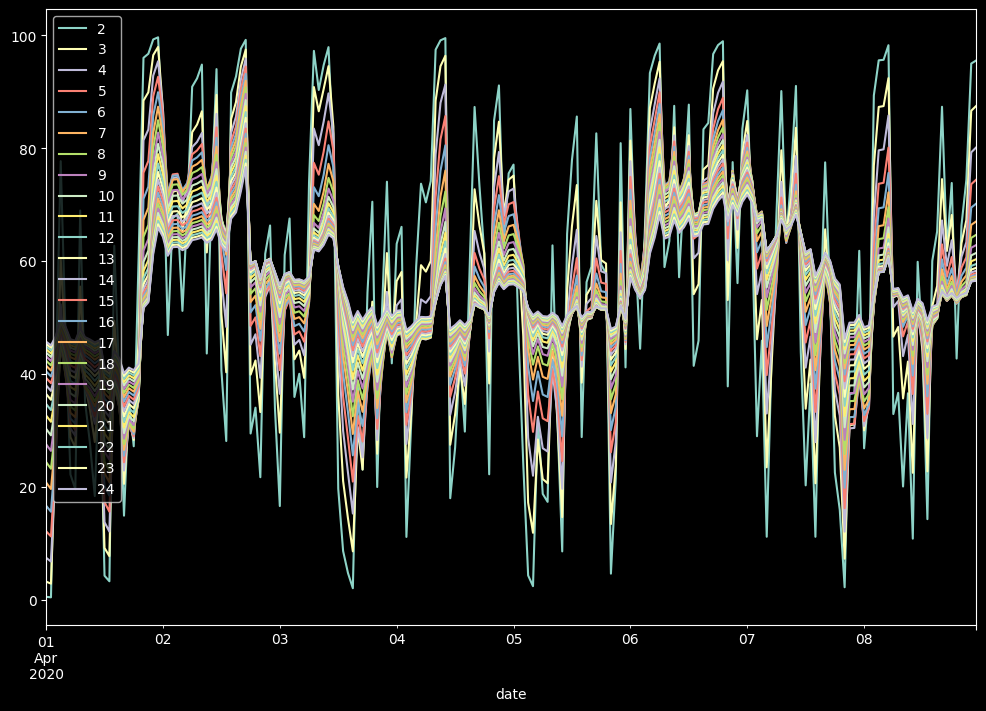

In [5]:
rsis["2020-04-01":"2020-04-08"].plot(figsize=(12, 8))
plt.show()

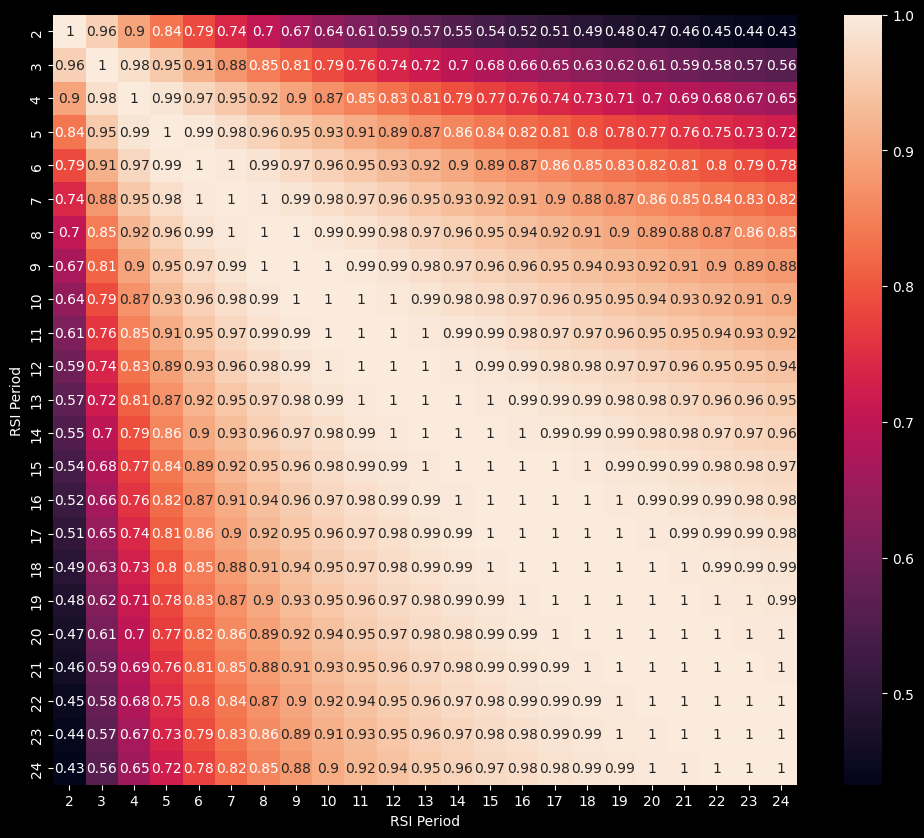

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(rsis.corr(), annot=True)
plt.xlabel("RSI Period")
plt.ylabel("RSI Period")
plt.show()

### Principal Component Analysis

In [7]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data[data.index < '2020-01-01']

In [8]:
rsi_periods = list(range(2, 25))
rsis = pd.DataFrame()
for p in rsi_periods:
    rsis[p] = ta.rsi(data['close'], p)

rsi_means = rsis.mean()
rsis -= rsi_means
rsis = rsis.dropna()

In [9]:
# Find covariance and compute eigen vectors
cov = np.cov(rsis, rowvar=False)
evals , evecs = la.eigh(cov)
# Sort eigenvectors by size of eigenvalue
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
evals = evals[idx]

n_components = 4
rsi_pca = pd.DataFrame()
for j in range(n_components):
    rsi_pca['PC' + str(j)] = pd.Series( np.dot(rsis, evecs[j]) , index=rsis.index)

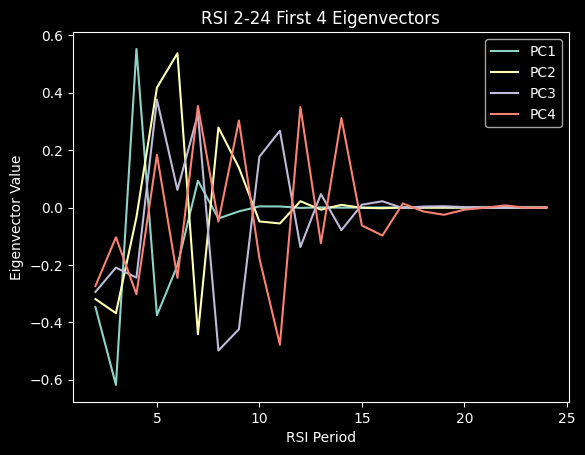

In [10]:
plt.style.use('dark_background')
for j in range(n_components):
    pd.Series(evecs[j], index=rsi_periods).plot(label='PC' + str(j+1))
plt.title("RSI 2-24 First 4 Eigenvectors")
plt.xlabel("RSI Period")
plt.ylabel("Eigenvector Value")
plt.legend()
plt.show()

### Model In Sample

In [11]:
def pca_linear_model(x: pd.DataFrame, y: pd.Series, n_components: int, thresh: float= 0.01):
    # Center data at 0
    means = x.mean()
    x -= means
    x = x.dropna()

    # Find covariance and compute eigen vectors
    cov = np.cov(x, rowvar=False)
    evals , evecs = la.eigh(cov)
    # Sort eigenvectors by size of eigenvalue
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    # Create data set for model
    model_data = pd.DataFrame()
    for j in range(n_components):
         model_data['PC' + str(j)] = pd.Series( np.dot(x, evecs[j]) , index=x.index)
    
    cols = list(model_data.columns)
    model_data['target'] = y
    model_coefs = la.lstsq(model_data[cols], y)[0]
    model_data['pred'] = np.dot( model_data[cols], model_coefs)

    l_thresh = model_data['pred'].quantile(0.99)
    s_thresh = model_data['pred'].quantile(0.01)

    return model_coefs, evecs, means, l_thresh, s_thresh, model_data

In [12]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = data[data.index < '2020-01-01']

In [13]:
rsi_periods = list(range(2, 25))
rsis = pd.DataFrame()
for p in rsi_periods:
    rsis[p] = ta.rsi(data['close'], p)

target = np.log(data['close']).diff(6).shift(-6)

In [14]:
# Drop nans
rsis['tar'] = target
rsis = rsis.dropna()
target = rsis['tar']
rsis = rsis.drop('tar',axis=1)
coefs, _, means, l_thresh, s_thresh, model_data =  pca_linear_model(rsis, target, 3)

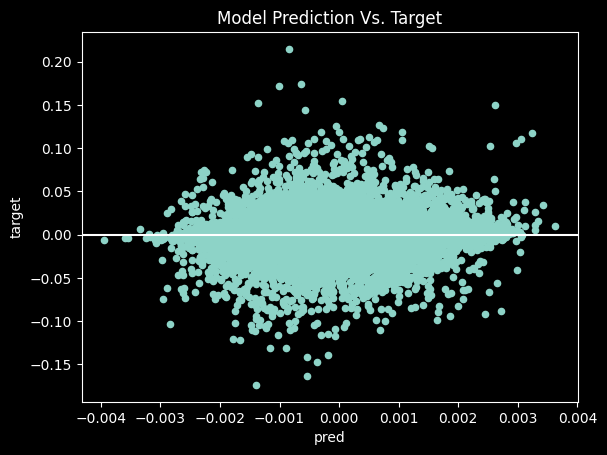

In [15]:
plt.style.use('dark_background')
model_data.plot.scatter('pred', 'target')
plt.title("Model Prediction Vs. Target")
plt.axhline(0.0, color='white')
plt.show()

### Walk Forward

In [16]:
def pca_rsi_model(
        ohlc: pd.DataFrame, rsi_lbs: List[int], train_size: int, step_size: int,  
        n_components: int = 2, lookahead: int = 6
):    
    rsis = pd.DataFrame()
    for lb in rsi_lbs:
        rsis[lb] = ta.rsi(ohlc['close'], lb)

    warm_up = max(rsi_lbs) * 2
    next_train = warm_up + train_size
    tar = np.log(ohlc['close']).diff(lookahead).shift(-lookahead)

    # Outputs
    model_pred = np.zeros(len(ohlc))
    long_thresh = np.zeros(len(ohlc))
    short_thresh = np.zeros(len(ohlc))
    signal = np.zeros(len(ohlc))

    model_pred[:] = np.nan
    long_thresh[:] = np.nan
    short_thresh[:] = np.nan

    rsi_means = None
    evecs = None
    model_coefs = None
    l_thresh = None
    s_thresh = None
    for i in range(next_train, len(ohlc)):
        if i == next_train:
            # Get RSI values in window, prevent future leak
            train_data = rsis.iloc[i - train_size: i + 1 - lookahead].copy()
            y = tar.reindex(train_data.index)
            
            model_coefs, evecs, rsi_means, l_thresh, s_thresh, _ =  pca_linear_model(train_data, y, n_components)
            next_train += step_size
        
        curr_row = rsis.iloc[i] - rsi_means
        vec = np.zeros(n_components)
        for j in range(n_components):
            vec[j] = np.dot(curr_row, evecs[j])
        curr_pred = np.dot(vec, model_coefs)

        model_pred[i] = curr_pred
        long_thresh[i] = l_thresh 
        short_thresh[i] = s_thresh
        if curr_pred > l_thresh:
            signal[i] = 1
        elif curr_pred < s_thresh:
            signal[i] = -1

    # Output dataframe
    output_df = pd.DataFrame(index=ohlc.index)
    output_df['pred'] = model_pred
    output_df['long_thresh'] = long_thresh
    output_df['short_thresh'] = short_thresh
    output_df['signal'] = signal
    # Keep signals normalized to -1 1
    output_df['signal'] = output_df['signal'].rolling(lookahead).mean()     
    return output_df

In [17]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [18]:
lookahead = 6
output = pca_rsi_model(data, list(range(2, 25)), 24 * 365 * 2, 24 * 365, n_components=3, lookahead=lookahead)
output['t'] = np.log(data['close']).diff(lookahead).shift(-lookahead)

print("Mean Target Above Long Threshold", output[output['pred'] > output['long_thresh']]['t'].mean())
print("Mean Target Below Short Threshold", output[output['pred'] < output['short_thresh']]['t'].mean())

Mean Target Above Long Threshold 0.004833148501313357
Mean Target Below Short Threshold -0.00802227157297084


In [19]:
next_r = np.log(data['close']).diff().shift(-1)
data['strat_ret'] = next_r * output['signal']

# Profit fac
pf = data[data['strat_ret'] > 0]['strat_ret'].sum() / data[data['strat_ret'] < 0]['strat_ret'].abs().sum()
print("Profit Factor", pf)

Profit Factor 1.4599528670670034


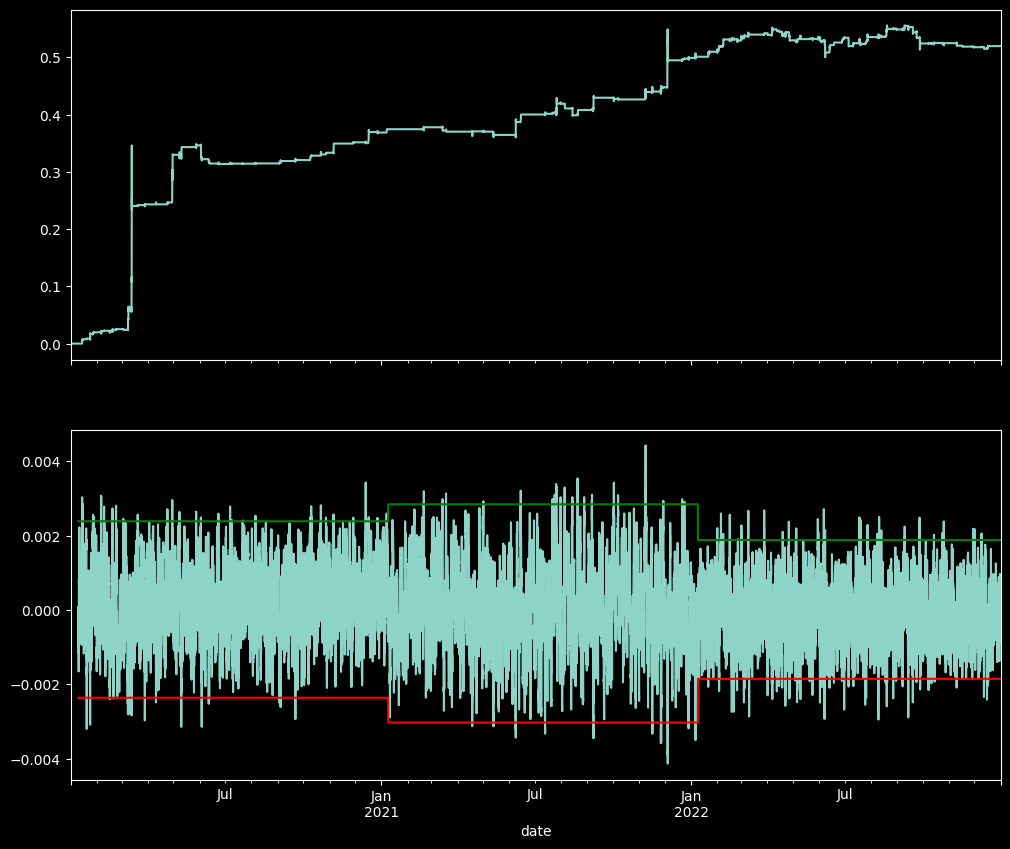

In [20]:
plt.style.use("dark_background")

data['r'] = next_r

data = data[data.index > '2020-01-01']
output = output[output.index > '2020-01-01']

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 10))
data['strat_ret'].cumsum().plot(label='RSI-PSA 3-6 Model', ax=axs[0])

output['pred'].plot(ax=axs[1])
output['long_thresh'].plot(ax=axs[1], color='green')
output['short_thresh'].plot(ax=axs[1], color='red')
plt.show()

In [21]:
# Heatmap code
next_r = np.log(data['close']).diff().shift(-1)
pf_df = pd.DataFrame()
for lookahead in tqdm(list(range(1, 25))):
    for n_components in [1,2,3,4,5,6]:
        output = pca_rsi_model(data, list(range(2, 25)), 24 * 365 * 2, 24 * 365, n_components=n_components, lookahead=lookahead)
        output['t'] = np.log(data['close']).diff(lookahead).shift(-lookahead)
        data['strat_ret'] = next_r * output['signal']

        # Profit fac
        pf = data[data['strat_ret'] > 0]['strat_ret'].sum() / data[data['strat_ret'] < 0]['strat_ret'].abs().sum()
        # print(pf)

        pf_df.loc[lookahead, n_components] = pf

  0%|          | 0/24 [00:00<?, ?it/s]

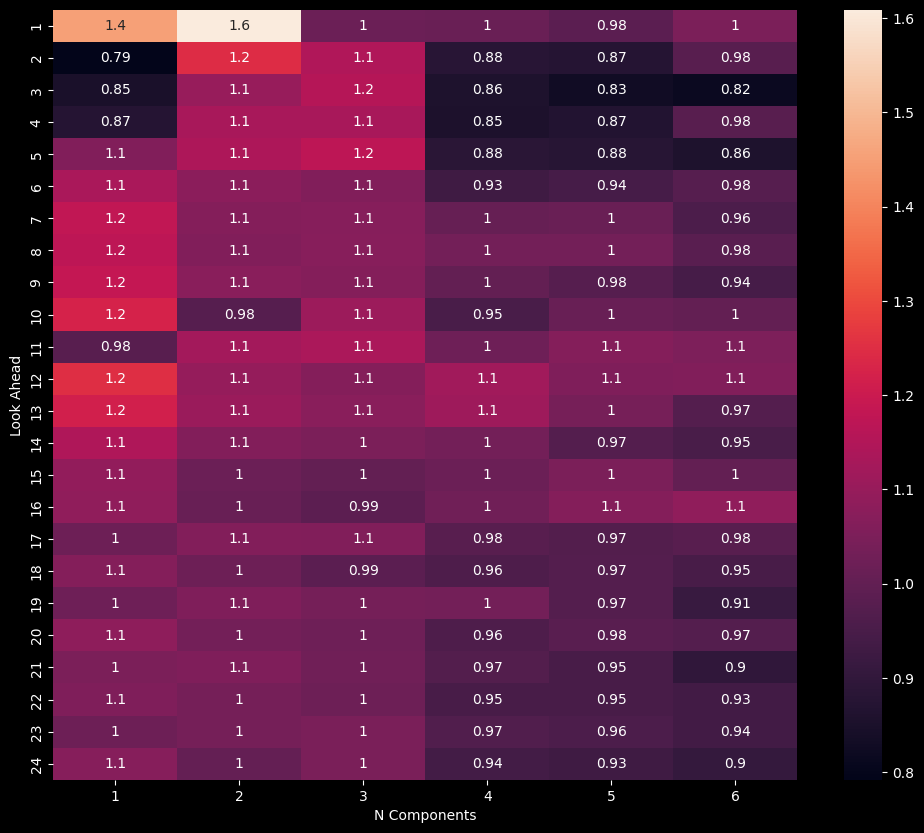

In [22]:
plt.style.use("dark_background")
plt.figure(figsize=(12, 10))
sns.heatmap(pf_df, annot=True)
plt.xlabel("N Components")
plt.ylabel("Look Ahead")
plt.show()